# Load package and data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.svm import SVC, OneClassSVM
from sklearn.cluster import SpectralClustering, KMeans
import pickle

In [2]:
feat_df = pd.read_pickle('working/feat_sample.pkl')
feat_df.head()

,filename,label,time_frequency,time_frequency_3d,cepstral_features
1068,data/fan/id_02/normal/00000810.wav,1,"[0.010177672, 0.012029049, 0.013606661, 0.0148...","[[[0.010177672, 0.012029049, 0.013606661, 0.01...","[1342.3212, -169.33577, 56.431564, -12.343427,..."
1371,data/fan/id_04/normal/00000679.wav,1,"[0.024199693, 0.023569148, 0.019138765, 0.0124...","[[[0.024199693, 0.023569148, 0.019138765, 0.01...","[2281.8855, -189.74542, 69.804276, -6.050237, ..."
2005,data/valve/id_06/normal/00000517.wav,1,"[0.0101727145, 0.011456816, 0.012681167, 0.013...","[[[0.0101727145, 0.011456816, 0.012681167, 0.0...","[756.97705, -236.23352, 26.00385, -2.6535478, ..."
981,data/fan/id_04/abnormal/00000188.wav,0,"[0.0080217095, 0.011077157, 0.01367029, 0.0154...","[[[0.0080217095, 0.011077157, 0.01367029, 0.01...","[235.9078, -155.51778, 32.71039, -6.1253037, 4..."
665,data/fan/id_04/normal/00000943.wav,1,"[0.0369246, 0.036855336, 0.03460157, 0.0312877...","[[[0.0369246, 0.036855336, 0.03460157, 0.03128...","[2645.254, -213.74278, 82.40141, -0.6766622, 1..."


In [3]:
with open('working/dump.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [20]:
filename= np.array(b['filename'])
label= np.array(b['label'])
cepstral_features=np.array(b['cepstral_features'])

In [6]:
time_frequency_3d=np.array(b['time_frequency_3d'])

In [11]:
time_frequency_3d.shape

(1000, 8, 610, 313)

In [43]:
time_frequency=time_frequency_3d.reshape(1000,8*610*313)

In [17]:
time_frequency.shape

(1000, 8, 190930)

In [ ]:
time_freq_3d = feat_df['time_frequency_3d'].to_numpy().flatten()
time_freq = feat_df['time_frequency'].to_numpy().flatten()
cepstral = feat_df['cepstral_features'].to_numpy().flatten()
comb = np.vstack((feat_df['cepstral_features'].values, feat_df['time_frequency'].values)).transpose()
cepstral

In [ ]:
comb.dtype

# Clustering

## Using PCA

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(cepstral_features)

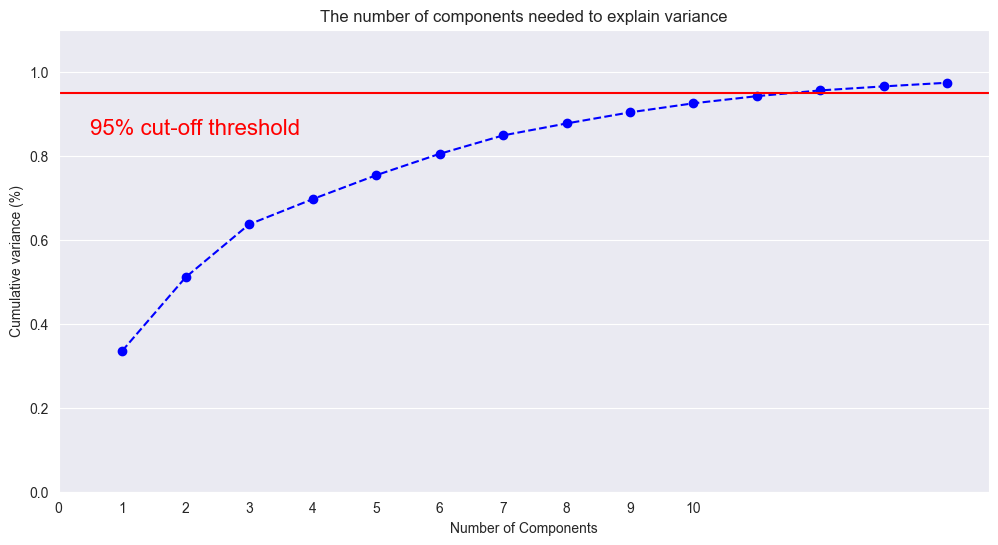

In [37]:
pca = PCA(n_components=14).fit(X)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 15, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance - Ceptstral Features')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [44]:
scaler = StandardScaler()
X = scaler.fit_transform(time_frequency)

ValueError: x and y must have same first dimension, but have shapes (14,) and (50,)

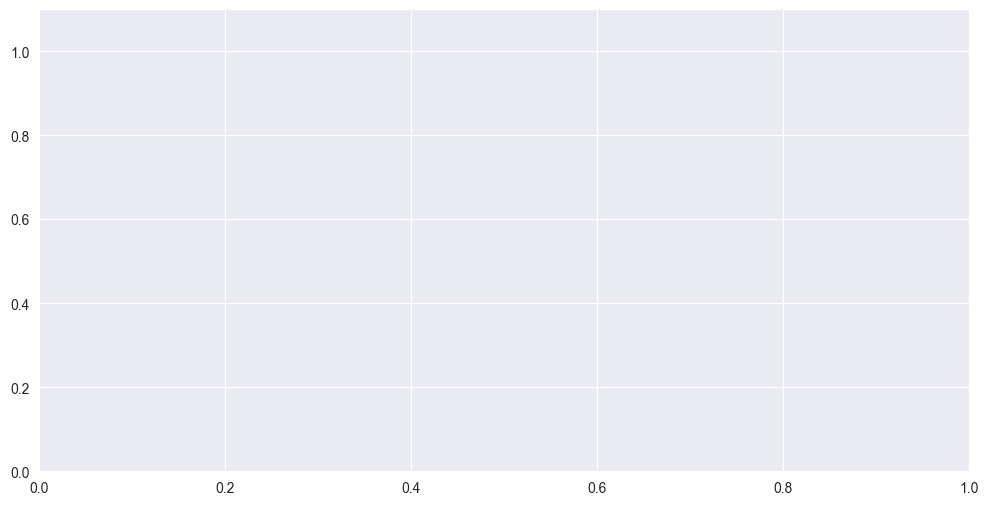

In [48]:
pca = PCA(n_components=50).fit(X)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 15, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance - Ceptstral Features')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [47]:
#PCA for reducing dimensions to 3
pca = PCA(n_components=10)
pca_X = pca.fit_transform(X)


colors = np.array([x for x in 'bgrcmykbgr'])
#running k-means on resuts of pca
km_pca = KMeans(n_clusters=2).fit(pca_X)
fig = px.scatter_3d(x=pca_X[:,7], y=pca_X[:,8], z=pca_X[:,9],color=colors[km_pca.labels_])
fig.show()

In [39]:
km_pca.labels_

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,

In [46]:
label

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,

In [40]:
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(label, km_pca.labels_)

array([[125, 111],
       [392, 372]], dtype=int64)